# Introduction

In recent years, there has been a significant increase in the ease of accessing geospatial data. This is attributed to various factors, including advancements in remote sensing technology, the greater availability of satellite imagery, and enhanced collaboration between governmental institutions and private organizations in making geospatial data available.

Multiple space agencies, such as NASA and the European Space Agency (ESA), have launched satellites with the capacity to capture high-resolution images of Earth. These images are increasingly accessible and available either for free or at affordable prices, suitable for various applications. Furthermore, private companies like DigitalGlobe and Planet have also invested in satellite constellations, providing high-quality commercial imagery.

In addition to satellite imagery, there is also a rise in the availability of data collected by crewed and unmanned aircraft, commonly known as drones. Drones enable the capture of high-resolution geospatial images in specific areas, offering more detailed and flexible data collection.

Moreover, many governments and institutions have been working towards making their geospatial data open and accessible. For instance, the Landsat program, a collaboration between NASA and the United States Geological Survey (USGS), provides an extensive collection of high-quality satellite images free of charge to the public.

<center><img src="https://developers.google.com/static/earth-engine/images/Code_editor.png" height=350></center>


Additionally, online platforms and services have emerged, providing easy access to geospatial data, enabling researchers, scientists, businesses, and the general public to explore and utilize these datasets. Examples of such platforms include Google Earth Engine, offering an extensive collection of satellite imagery and analysis tools, and OpenStreetMap, a collaborative project that provides geospatial data from around the world.

With this increased accessibility to geospatial data, opportunities for research, innovation, and the application of computer vision also expand. This enables more individuals and organizations to explore and harness this information for a wide range of purposes, from evidence-based decision-making to the development of solutions for global challenges.

## Context

The Indigenous Land (IL) Mãe Maria, located in the Amazon Region, specifically in the southern part of the state of Pará, is home to three indigenous groups: Gavião Akrãtikatêjê, Gavião Kykatejê, and Gavião Parkatêjê, totaling 709 inhabitants in an area of 62,488 hectares. These communities face **conflicts** stemming from various activities, such as **governmental entities' actions, dam and hydroelectric power plant construction, the establishment of waterways, highways, railways, port complexes/terminals, and airports, in addition to public policies and environmental legislation.**

## Project Objective

Our objective is to examine the consequences on vegetation cover in Indigenous Land Mãe Maria, utilizing the Normalized Difference Vegetation Index (NDVI) to assess variations in vegetation between the years 2013 and 2023. To achieve this objective, we will construct a sequential process encompassing the collection of information from the distinct spectral bands of the Landsat 8 satellite.


# 1. Introduction to Google Earth Engine (Python API)

To find a set of meteorological data, you can visit the [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog).

The **Earth Engine Data Catalog** is a public catalog that includes a variety of standard Earth science raster datasets that can be imported into your script environment with a single click. In it, you can find datasets such as:

- [Global SRTM elevation data](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) with a 30m resolution
- [OpenLandMap datasets](https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_CLAY-WFRACTION_USDA-3A1A1A_M_v02) with soil properties at a 250m resolution
- Temperature, precipitation, and evapotranspiration data from [GRIDMET](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET).

Furthermore, the catalog also allows you to upload your own raster or vector data for private use or sharing within your scripts. The available data includes imagery from a variety of satellites and sensors, making it an invaluable resource for geospatial analysis.

## 1.1 Accessing and Authenticating with Google Earth Engine

To access and utilize all the provided free resources, you need to have a Google account and request access to the Google Earth Engine platform. Once access is granted, you can start using the Google Earth Engine Code Editor to write and execute scripts to access, analyze, and visualize the available data.


In [ ]:
# Import the necessary libraries
import ee
import cv2
import numpy as np
import matplotlib.pyplot as plt

# This line enables plots to be displayed directly in the notebook
%matplotlib inline

# Configure the matplotlib library to use 'gray' as the default color map for images
plt.rcParams['image.cmap'] = 'gray'

# Import the gdal library from osgeo, used for manipulating geospatial files
from osgeo import gdal


In [ ]:
# Trigger the authentication flow
ee.Authenticate()

# Initialize the library
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=iSiWBfH5yek3g-MruUnzcztN86lg1VXWVUtp3Tx1fzw&tc=E2pFjLHH8CCXmIdVZAqUldhzocW1BBJZbpSdvbpWNv0&cc=lGTaH1823DIbL5Afqfc7SbEqsbRZe2K61ytcePk53Vk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AZEOvhXmKcLX5NmBOPiKCvMAJPSEahin7yYlbMSrI6qH6KQBPb-2D8ktkrk

Successfully saved authorization token.


In [ ]:
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


In [ ]:
ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_044034_20201028')

## 1.2 Extracting Images (GeoTiffs) from Google Earth Engine

Extracting images from Google Earth Engine involves running scripts to request and process satellite image data. The Google Earth Engine platform allows you to select a specific image collection, apply temporal and spatial filters to choose images that meet your needs, and then apply image processing algorithms to manipulate the image data. For example, you can extract vegetation or land cover data, perform change analysis over time, among other functions.

In [ ]:
def cloud_mask_l8(image):
    qa = image.select('QA_PIXEL')

    # Bits 3 and 5 are cloud shadow and cloud, respectively.
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
             .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

    return image.updateMask(mask)

In [ ]:
# Import the USGS Landsat 8 Level 2, Collection 2, Tier 1 collection
# lc = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Define a polygon around the Indigenous Land Mãe Maria, Marabá PA - Brazil
geometry = ee.Geometry.Polygon(
    [[  [-49.04623050643278,-4.950390341620249],
        [-49.04623050643278,-5.269785188531088],
        [-48.80665817202447,-5.269785188531088],
        [-48.80665817202447,-4.950390341620249]]],
        None,
        False)

# Define the parameters for Landsat 8.
landsat8_params = {
  "bands": ['SR_B4', 'SR_B3', 'SR_B2'],
  "min": 0.0,
  "max": 30000.0,
  "gamma": 1.0
}

# Filter the Landsat 8 image collection for the year 2013 and apply cloud masking.
dataset13 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2013-01-01', '2013-12-31').map(cloud_mask_l8)
landsat13 = dataset13.median().clip(geometry)

# Filter the Landsat 8 image collection for the year 2018 and apply cloud masking.
dataset18 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-01-01', '2018-12-31').map(cloud_mask_l8)
landsat18 = dataset18.median().clip(geometry)

# Filter the Landsat 8 image collection for the year 2023 and apply cloud masking.
dataset23 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2023-01-01', '2023-12-31').map(cloud_mask_l8)
landsat23 = dataset23.median().clip(geometry)


## 1.3 Displaying Satellite Images on Maps

One of the major advantages of Google Earth Engine is its capability to effectively visualize remote sensing data. After selecting and processing image data, you can display satellite images on an interactive map. This is achieved by adding the processed images as layers to a Google Earth Engine Map. This map can be interactively explored and manipulated, allowing for a clear and detailed view of the data.

In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
    """
    Adds a Google Earth Engine image layer to a folium map.

    Args:
        self (object): folium map object to which the layer will be added.
        ee_image_object (ee.image.Image): Google Earth Engine image to be added to the folium map.
        vis_params (dict): Visualization parameters for the image.
            This dictionary should at least contain a 'bands' property.
            For example, { 'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'max': 0.3 }.
        name (str): Name of the layer to be added.

    Returns:
        None

    Example:
        # Define a folium map
        mapa = folium.Map(location=[-15.783333, -47.866667], zoom_start=12)

        # GEE image
        image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_220071_20170805')

        # Visualization parameters
        vis = { 'bands': ['B4', 'B3', 'B2'], 'max': 0.3 }

        # Add the image to the map
        mapa.add_ee_layer(image, vis, 'Brasilia Landsat')

        # Display the map
        display(mapa)
    """
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the Google Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Center the map around Indigenous Land Mãe Maria, Marabá PA - Brazil
map = folium.Map(location=(-5.199, -49.3989), zoom_start=12)

# Adding the generated images to the map.
map.add_ee_layer(lansat13, landsat8_params, '2013')
map.add_ee_layer(lansat18, landsat8_params, '2018')
map.add_ee_layer(lansat23, landsat8_params, '2023')

# Add a layer control panel to the map.
map.add_child(folium.LayerControl())

# Display the map.
display(map)


## 1.4 Saving Google Earth Images as GeoTiffs

Google Earth Engine allows you to export processed data, including satellite images, in various formats. One of the most common formats is GeoTiff, which is a TIFF image format that includes geospatial metadata, enabling the image to be used in Geographic Information Systems (GIS). To save images as GeoTiffs, you need to define an export task in the Google Earth Engine Code Editor and choose Google Drive as the export destination. The processed image will be saved in your Google Drive, ready to be downloaded and used in other analyses or GIS visualizations.

In [ ]:
# Define a polygon based on the new coordinates
geometry = ee.Geometry.Polygon(
    [[  [-49.04623050643278,-4.950390341620249],
        [-49.04623050643278,-5.269785188531088],
        [-48.80665817202447,-5.269785188531088],
        [-48.80665817202447,-4.950390341620249]]],
        None,
        False)

# Define the parameters for Landsat 8.
landsat8_params = {
  "bands": ['SR_B4', 'SR_B3', 'SR_B2'],
  "min": 0.0,
  "max": 30000.0,
  "gamma": 1.0
}

# Filter the Landsat 8 image collection for the year 2013 and apply cloud masking.
dataset13 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2013-01-01', '2013-12-31').map(cloud_mask_l8)
lansat13 = dataset13.median().clip(geometry)

# Filter the Landsat 8 image collection for the year 2018 and apply cloud masking.
dataset18 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-01-01', '2018-12-31').map(cloud_mask_l8)
lansat18 = dataset18.median().clip(geometry)

# Filter the Landsat 8 image collection for the year 2023 and apply cloud masking.
dataset23 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2023-01-01', '2023-12-31').map(cloud_mask_l8)
lansat23 = dataset23.median().clip(geometry)


In [ ]:
# Task configuration (task_config) to export the images to Google Drive
task_config = {
  'folder': 'deforestation',  # Folder where the images will be saved
  'scale': 30,  # Spatial resolution of the images in meters
  'region': geometry,  # Area of interest (region) for image export
  'fileFormat': 'GeoTIFF',  # Output file format of the images
  'maxPixels': 1e9,  # Maximum number of pixels allowed for export
  'formatOptions': {
    'cloudOptimized': True  # Option to optimize the images for fast cloud access
  }
}

# Task 1: Export the Landsat 13 image to Google Drive
task1 = ee.batch.Export.image.toDrive(lansat13, description='2013api', **task_config)

# Task 2: Export the Landsat 18 image to Google Drive
task2 = ee.batch.Export.image.toDrive(lansat18, description='2018api', **task_config)

# Task 3: Export the Landsat 23 image to Google Drive
task3 = ee.batch.Export.image.toDrive(lansat23, description='2023api', **task_config)


In [ ]:
# Start the execution of export tasks for Landsat images to Google Drive
task1.start()
task2.start()
task3.start()


In [ ]:
# Check the execution status of task1. (READY,RUNNING OR COMPLETED)
print(task1.status())


{'state': 'COMPLETED',
 'description': '2013api',
 'creation_timestamp_ms': 1689793417074,
 'update_timestamp_ms': 1689793657674,
 'start_timestamp_ms': 1689793426611,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1yWsMEUqsofkUuTGPPDI7NkiXnt60dCCN'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 317.962890625,
 'id': 'NDL3DGWCHQFNWN3EBKAHS5CU',
 'name': 'projects/earthengine-legacy/operations/NDL3DGWCHQFNWN3EBKAHS5CU'}

In [ ]:
# Check the execution status of task2.  (READY,RUNNING OR COMPLETED)
print(task2.status()['state'])

{'state': 'COMPLETED',
 'description': '2013api',
 'creation_timestamp_ms': 1689793417074,
 'update_timestamp_ms': 1689793657674,
 'start_timestamp_ms': 1689793426611,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1yWsMEUqsofkUuTGPPDI7NkiXnt60dCCN'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 317.962890625,
 'id': 'NDL3DGWCHQFNWN3EBKAHS5CU',
 'name': 'projects/earthengine-legacy/operations/NDL3DGWCHQFNWN3EBKAHS5CU'}

In [ ]:
# Check the execution status of task2 (READY,RUNNING OR COMPLETED)
task3.status()

{'state': 'COMPLETED',
 'description': '2013api',
 'creation_timestamp_ms': 1689793417074,
 'update_timestamp_ms': 1689793657674,
 'start_timestamp_ms': 1689793426611,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1yWsMEUqsofkUuTGPPDI7NkiXnt60dCCN'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 317.962890625,
 'id': 'NDL3DGWCHQFNWN3EBKAHS5CU',
 'name': 'projects/earthengine-legacy/operations/NDL3DGWCHQFNWN3EBKAHS5CU'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Geospatial Data Abstraction Library

GDAL, the Geospatial Data Abstraction Library, is a valuable tool for working with geospatial raster and vector data formats. The GDAL Python package provides a set of tools that enable efficient programming and manipulation of such data.

An important concept in geospatial image manipulation is that of a **raster band**. Common color images usually have 3 raster bands representing the intensity components of blue, green, and red light. However, a raster band can contain any set of cell values representing the same spatial area, not limited to just light intensity information.

Extracting raster data using GDAL is done one band at a time. The `GetRasterBand()` function allows us to extract a single raster band from the GeoTiff image.

### Function Syntax
```python
band = dataset.GetRasterBand( n )
```

The function has **1 mandatory input argument**:

1. `n` is the channel number to be extracted.

For further information, you can consult the [GDAL documentation](https://gdal.org/api/python/osgeo.gdal.html).

In this example, we are working with a GeoTIFF image of Landsat 8, which contains various bands listed below:

1. Coastal/Aerosol
2. Blue
3. Green
4. Red
5. Near Infrared
6. Shortwave Infrared 1
7. Shortwave Infrared 2
8. Panchromatic
9. Cirrus
10. Thermal Infrared 1
11. Thermal Infrared 2

We will visualize each of these bands to better understand the data.

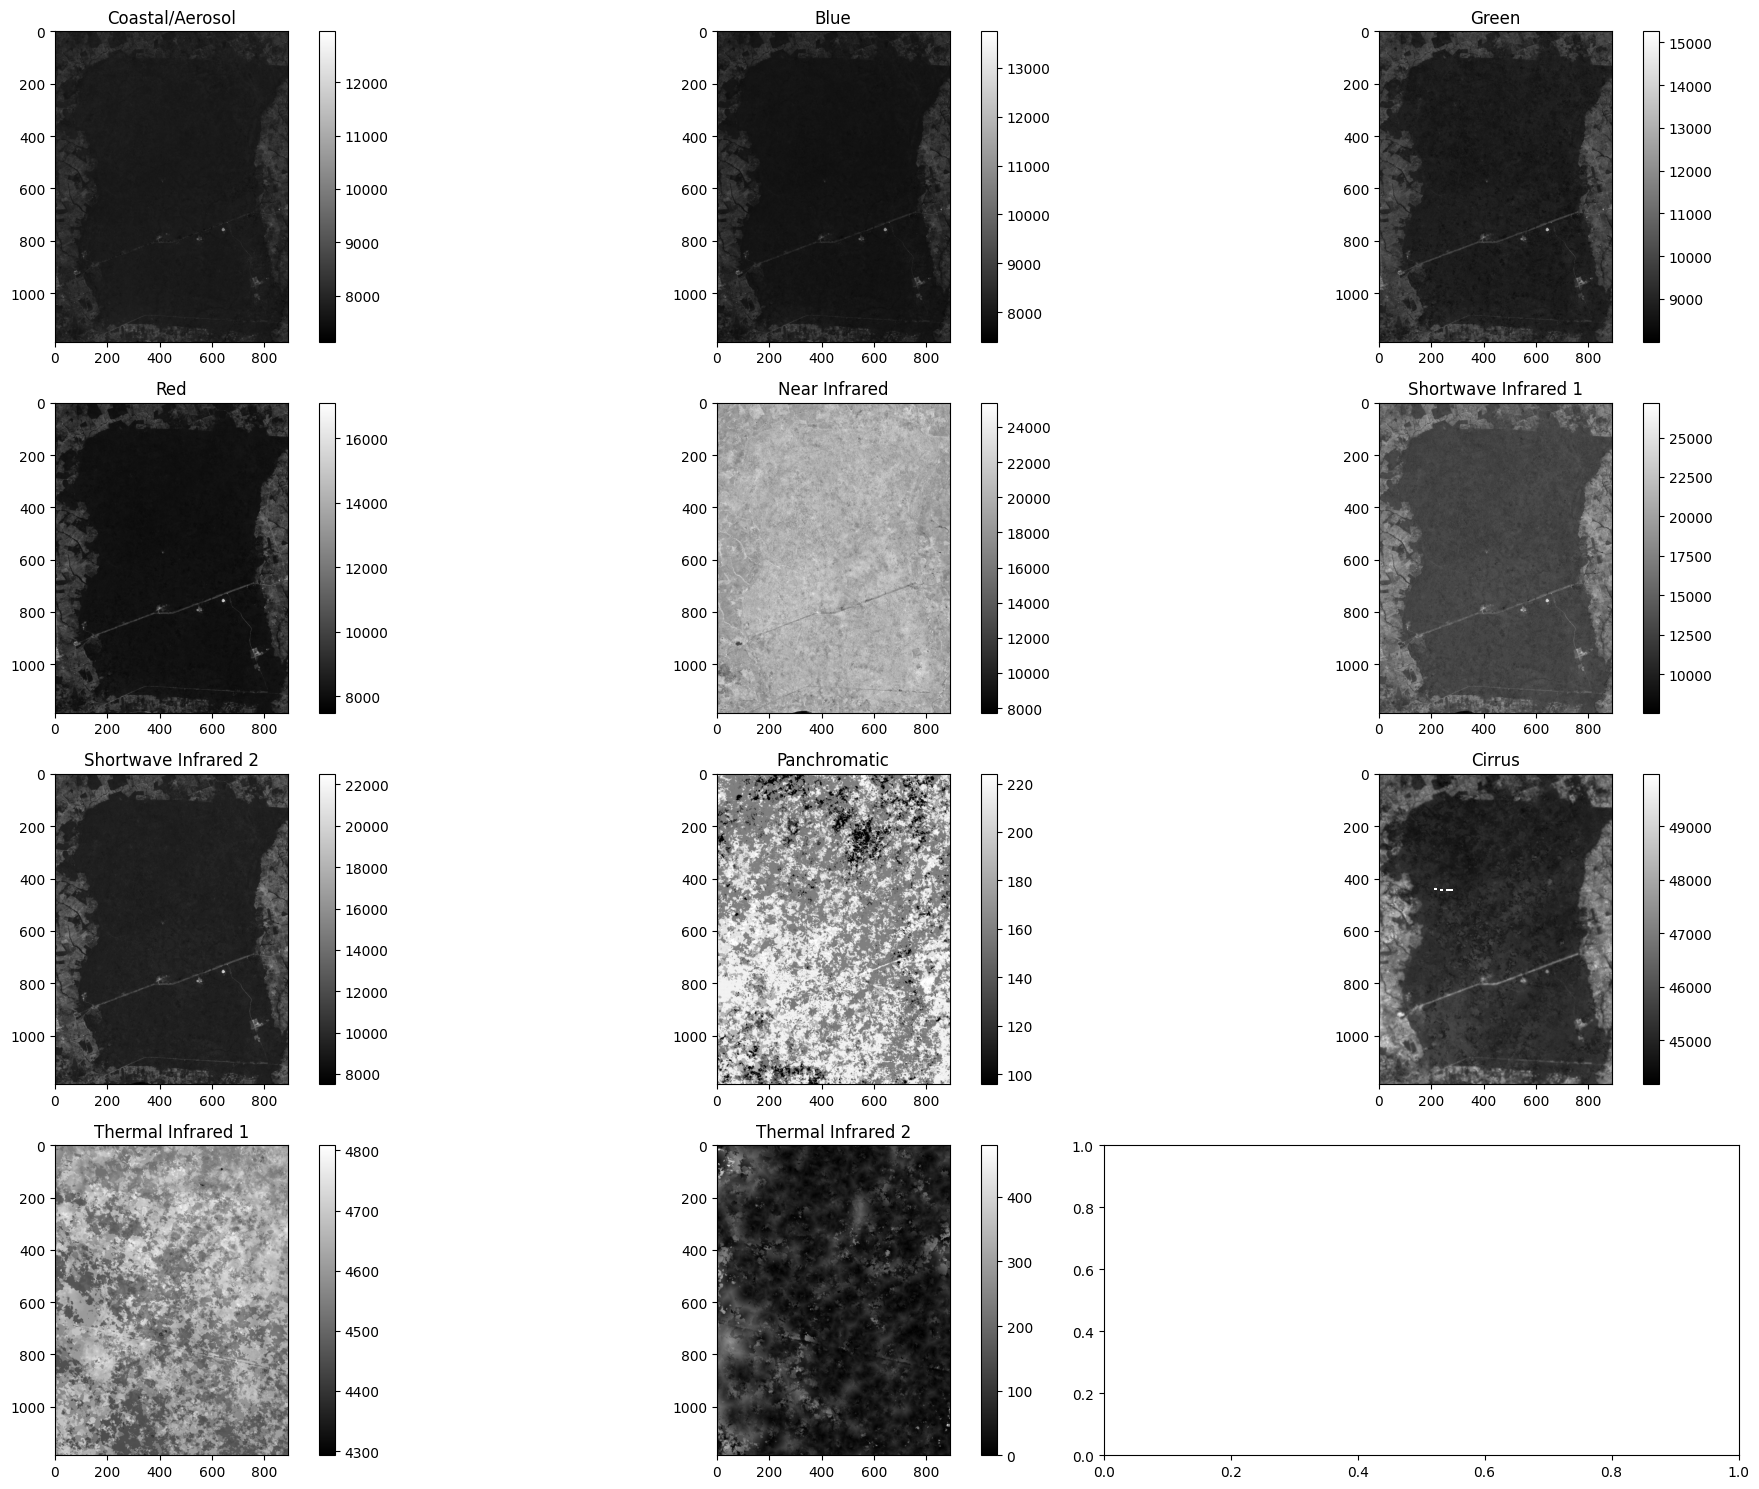

In [ ]:
# We use GDAL to open a specific geospatial file.
ds = gdal.Open('/content/drive/MyDrive/deforestation/2013api.tif')

# We create a dictionary that maps band numbers to their descriptive names.
band_names = {
    1: "Coastal/Aerosol",
    2: "Blue",
    3: "Green",
    4: "Red",
    5: "Near Infrared",
    6: "Shortwave Infrared 1",
    7: "Shortwave Infrared 2",
    8: "Panchromatic",
    9: "Cirrus",
    10: "Thermal Infrared 1",
    11: "Thermal Infrared 2",
}

# We created a grid of subplots with 4 rows and 3 columns, and set the size of the figure.
fig, axs = plt.subplots(4, 3, figsize=(20, 15))

# We iterate over each band and name in the `band_names` dictionary.
for band, name in band_names.items():
    # We identify the appropriate subplot in which to plot.
    ax = axs[(band - 1) // 3, (band - 1) % 3]
    # We read the data of the current band as an array and display it on the image.
    im = ax.imshow(ds.GetRasterBand(band).ReadAsArray())
    # We added a color bar to the image.
    fig.colorbar(im, ax=ax)
    # We set the title of the subplot with the band's name.
    ax.set_title(name)

# We used `tight_layout` to ensure that the subplots do not overlap.
plt.tight_layout()

# We displayed the figure.
plt.show()

## 3. Normalized Difference Vegetation Index (NDVI)

The **Normalized Difference Vegetation Index** or NDVI is an index used to demonstrate the difference between visible and near-infrared reflectance of vegetation cover, and **it can be used to estimate the green density in a land area**.

NDVI is calculated using the following formula:

$$
NDVI = (NIR - RED) / (NIR + RED)
$$

where `RED` and `NIR` represent the spectral reflectance measurements acquired in the red (visible) and near-infrared regions, respectively. The NDVI index for an area with vegetation should be between 0.3 (light vegetation) and 0.8 (dense vegetation). Clouds will have a negative index, while soil and water bodies will have low positive values. We will use this information to estimate the vegetation of a specific region.

In normalized values, that is, between (0, 255), the range of interest corresponds to intensities between 165 and 230.

**Near-Infrared (NIR) Region**

The **NIR** region has a wavelength of 0.76 - 0.90 µm. Plant life absorbs visible light from 0.4 µm (blue light) to 0.7 µm (red light) for photosynthesis, with maximum absorption at both ends of this spectrum. We see plants as green because they typically do not absorb the green wavelengths of light (~0.5 µm) in the middle of this range. However, this makes the green channel less precise for vegetation detection because it's within the full range of wavelengths used for photosynthesis. On the other hand, plants strongly reflect near-infrared light (0.7 to 1.1 µm). This fact is exploited in the calculation of NDVI.

In [ ]:
import cv2
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

def get_NDVI(ds):
    '''
    Calculate the Normalized Difference Vegetation Index (NDVI) for an image.

    Arguments:
    ds -- An opened GDAL dataset object representing the image

    Returns:
    ndvi -- A numpy array representing the NDVI of the image
    '''
    r = ds.GetRasterBand(4).ReadAsArray()   # Red band is the 4th
    nir = ds.GetRasterBand(5).ReadAsArray() # NIR band is the 5th
    ndvi = (nir - r) / (nir + r)
    ndvi = normalize255(ndvi)
    return ndvi

def normalize255(ndvi):
    '''
    Normalize an NDVI matrix to the range of 0 to 255.

    Arguments:
    ndvi -- A numpy array representing the NDVI

    Returns:
    ndvi -- The normalized NDVI array
    '''
    ndvi = ndvi + 1
    ndvi = (ndvi / 2) * 255
    return ndvi

def get_NDVI_mask(ndvi):
    '''
    Create a threshold mask for vegetation areas in an NDVI matrix.

    Arguments:
    ndvi -- A numpy array representing the NDVI

    Returns:
    mask -- A binary matrix where values of 1 represent vegetation
    '''
    _, mask = cv2.threshold(ndvi, 170, 255, cv2.THRESH_BINARY)
    return mask

def percent_forest(mask):
    '''
    Calculate the percentage of vegetation pixels in a mask.

    Arguments:
    mask -- A binary matrix where values of 1 represent vegetation

    Returns:
    percent -- The percentage of vegetation pixels
    '''
    c = cv2.countNonZero(mask)
    t = mask.shape[0] * mask.shape[1]
    return round((c / t) * 100, 4)

def plot_NDVI(path):
    '''
    Plot the NDVI and vegetation mask of an image and display the
    percentage of vegetation.

    Arguments:
    path -- The path to the image file
    '''
    ds = gdal.Open(path)
    ndvi = get_NDVI(ds)
    ndvi_mask = get_NDVI_mask(ndvi)

    year = path.split('.')[0][:4]
    fig = plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(ndvi, cmap="gray")
    plt.colorbar()
    plt.title(year + ": " + "NDVI")
    plt.xticks([]), plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(ndvi_mask, cmap="gray")
    plt.title(str(percent_forest(ndvi_mask)) + "%")
    plt.xticks([]), plt.yticks([])

    plt.show()


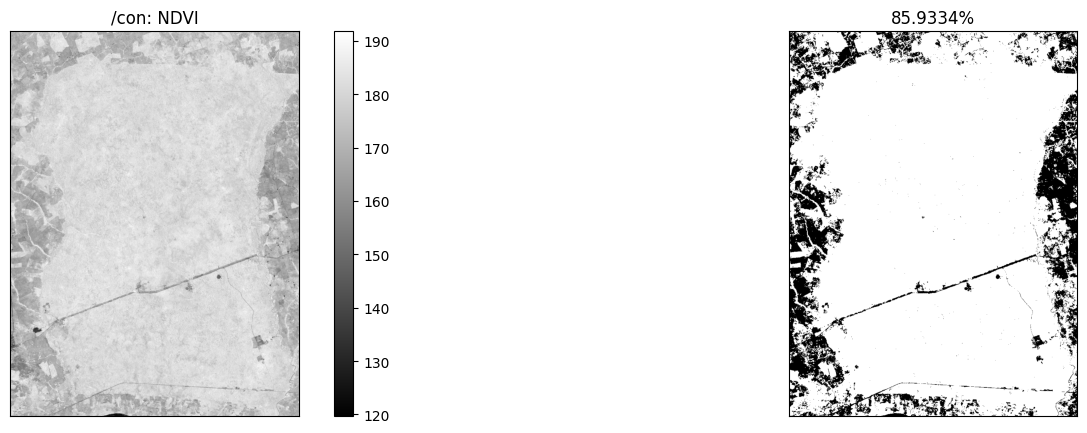

In [ ]:
plot_NDVI("/content/drive/MyDrive/deforestation/2013api.tif")

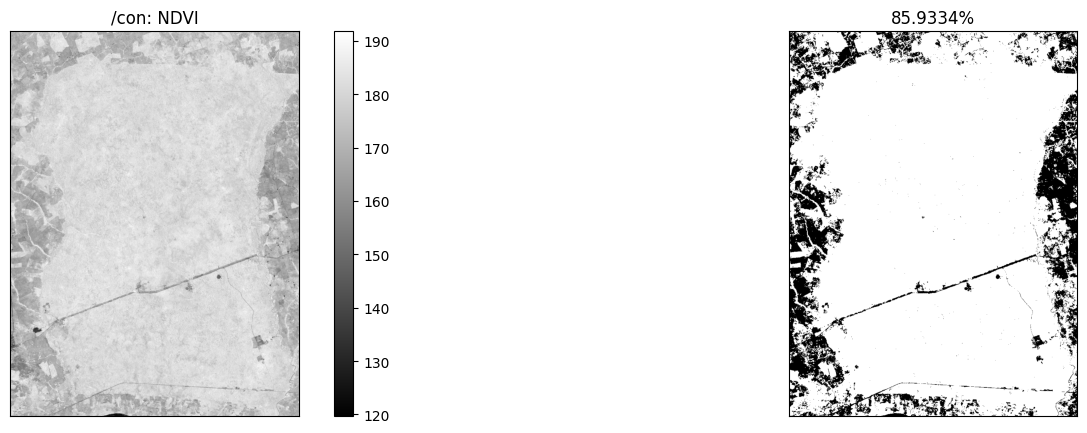

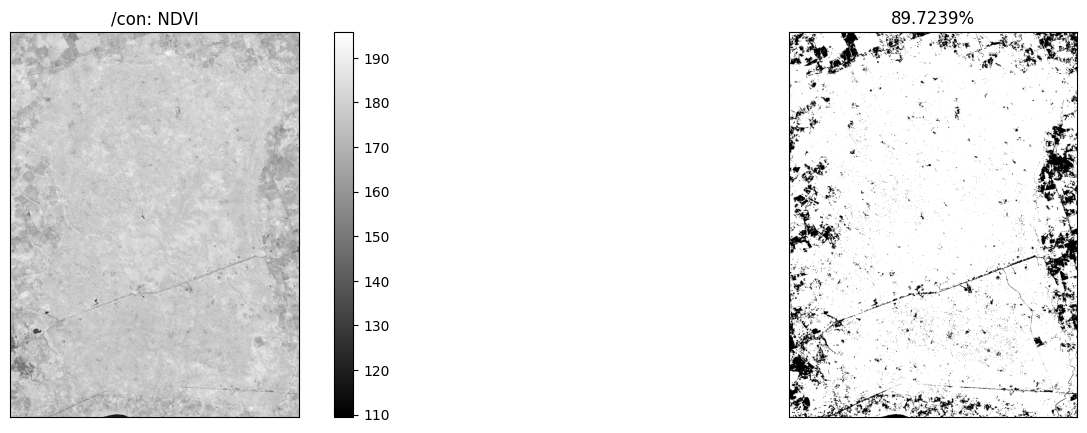

In [ ]:
files = [
    "/content/drive/MyDrive/deforestation/2013api.tif",
    "/content/drive/MyDrive/deforestation/2023api.tif"
]

for file in files:
    plot_NDVI(file)

## Conclusion

The analysis of the **Normalized Difference Vegetation Index (NDVI)** in satellite images of the Mãe Maria Indigenous Land revealed an increase of approximately **3.7905%** in vegetation cover between **2013 and 2023**. This is a positive sign of environmental recovery and preservation, despite the conflicts and pressures faced by indigenous communities in the region.

However, the ongoing need for environmental conservation and protection is emphasized to ensure a sustainable future for local communities and the ecosystem. The employed scientific approach highlights the importance of balancing human development and environmental preservation.